In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import edward as ed
from edward.models import Normal, MultivariateNormalDiag
from scipy.stats import multivariate_normal
from scipy.misc import logsumexp
from sem import SEM, KerasLDS, LinearDynamicSystem, KerasMultiLayerNN

Here, I'm defining the event segmentation model and a linear dymanic system that is used as the event model. See SEM project notes for details, but it's what's proposed


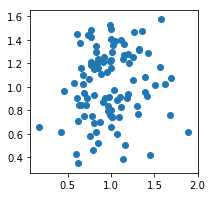

In [2]:
def build_2d_data(N, beta=0.1):
    """ 
    2d, Mulitvariate Guassian data
    """
    mu = [1, 1]
    Sigma = np.eye(2) * beta
    x = np.zeros((N, 2), dtype=np.float32)
    for n in range(N):
        x[n, :] = np.random.multivariate_normal(mu, Sigma)
        
    return x
X = build_2d_data(100)
plt.figure(figsize=(3,3))
plt.scatter(X[:,0], X[:, 1])

In [3]:
D = 2
X_train = X[0:-1]; y_train = X[1:]

Now, we define some toy problem

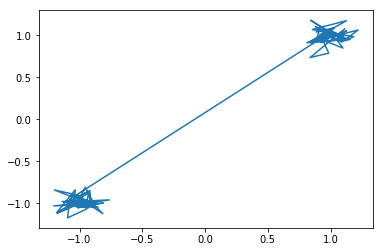

In [4]:
# first demo -- gaussian mixture defined by the CRP

def build_static_dataset(N, beta=0.1):
    """ 
    2 events, modeled as gaussians with different means
    """
    
    pi = np.array([0.4, 0.6])
    mus = [[1, 1], [-1, -1]]
    stds = np.ones((2, 2)) * beta
    x = np.zeros((N, 2), dtype=np.float32)
    for n in range(N/2):
        x[n, :] = np.random.multivariate_normal(mus[0], np.diag(stds[0]))
    for n in range(N/2, N):
        x[n, :] = np.random.multivariate_normal(mus[1], np.diag(stds[1]))
        
    return x

x_train = build_static_dataset(100, 0.01)
plt.plot(x_train[:, 0], x_train[:, 1])

In [5]:
K = 20  # maximum number of event types
lmda = 10  # stickyness parameter
alfa = 1.0  # concentration parameter
beta = 0.01 # transition noise
eta =  0.1  # learning rate

sem_kwargs = dict(lmda=lmda, alfa=alfa, beta=beta, 
                  f_class=LinearDynamicSystem, f_opts=dict(eta=eta))

sem = SEM(**sem_kwargs)
post = sem.run(x_train, K=K)

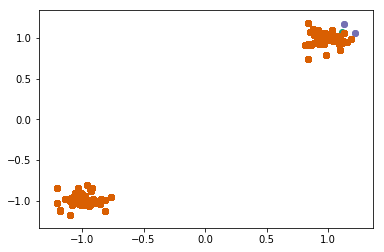

In [6]:
def plot_segmentation(post):
    cluster_id = np.argmax(post, axis=1)
    import seaborn as sns
    cc = sns.color_palette('Dark2', post.shape[1])
    for clt in cluster_id:
        idx = np.nonzero(cluster_id == clt)[0]
        plt.scatter(x_train[idx, 0], x_train[idx, 1], color=cc[clt])
        
plot_segmentation(post)

In [7]:
# Initialize keras model
sem_kwargs = dict(lmda=lmda, alfa=alfa, beta=beta, 
                  f_class=KerasLDS, f_opts=dict())

sem2 = SEM(**sem_kwargs)
post = sem2.run(x_train, K=K)

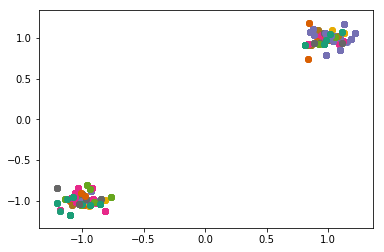

In [8]:
plot_segmentation(post)

In [9]:
#show the envent number that was chosen. Notice the re-use of events
np.argmax(post, axis=1)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 10, 14, 15,
       16, 17, 18, 19,  3,  2,  2,  3,  2,  2,  1, 11, 17,  5, 16, 16, 16,
        6,  2, 11, 11, 10, 10, 10, 10, 14, 14,  2,  2,  2,  7,  7,  8, 16,
       16, 13, 10, 16, 11,  3,  2, 12, 15,  3,  1,  2, 17,  4,  4,  5,  5,
        2,  2,  6, 19,  7,  0,  7, 12, 12, 12,  0, 19, 19, 19, 19, 19, 19,
       19, 19, 19, 19,  4,  4,  0, 10, 16, 16,  9, 15, 15, 15,  9])

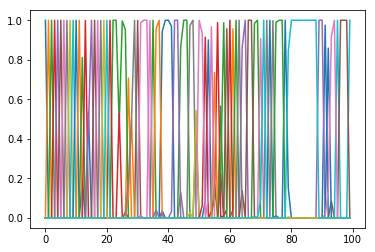

In [10]:
plt.plot(post)
plt.show()

In [11]:
# Initialize keras model
sem_kwargs = dict(lmda=lmda, alfa=alfa, beta=beta, 
                  f_class=KerasMultiLayerNN, f_opts=dict())

sem3 = SEM(**sem_kwargs)
post = sem3.run(x_train, K=K)

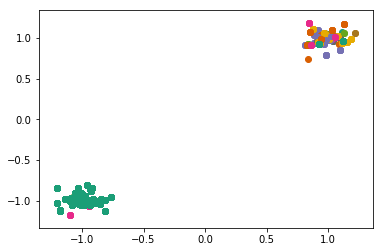

In [12]:
plot_segmentation(post)

In [13]:
#show the envent number that was chosen. Notice the re-use of events
np.argmax(post, axis=1)

array([ 0,  1,  2,  2,  3,  4,  5,  5,  6,  3,  7,  8,  8,  9, 10, 10, 10,
       11, 12, 13, 12, 12, 14, 15, 16, 15,  2, 15, 17, 18, 19,  2, 18, 18,
       13,  6, 17,  5,  5,  5,  5,  2,  3,  9,  9,  9, 13, 13, 13,  9,  4,
        3,  3,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8])

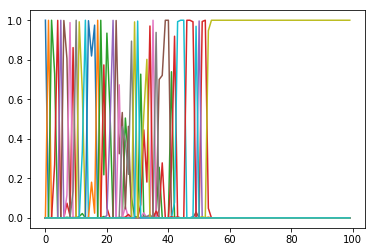

In [14]:
plt.plot(post)
plt.show()

Now, alternative between two events


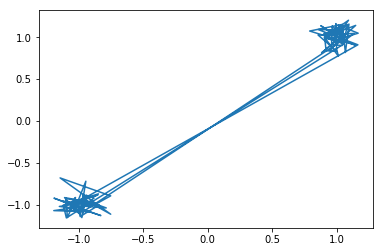

In [15]:
def build_alternating_static_events(N, beta=0.1):
    """ 
    2 alternating events, modeled as gaussians with different means
    """
    
    pi = np.array([0.4, 0.6])
    mus = [[1, 1], [-1, -1]]
    stds = np.ones((2, 2)) * beta
    x = np.zeros((N, 2), dtype=np.float32)
    for n in range(N/4):
        x[n, :] = np.random.multivariate_normal(mus[0], np.diag(stds[0]))
    for n in range(N/4, N/2):
        x[n, :] = np.random.multivariate_normal(mus[1], np.diag(stds[1]))
    for n in range(N/2, N/4*3):
        x[n, :] = np.random.multivariate_normal(mus[0], np.diag(stds[0]))
    for n in range(N/4*3, N):
        x[n, :] = np.random.multivariate_normal(mus[1], np.diag(stds[1]))
        
    return x

x_train = build_alternating_static_events(100, 0.01)
plt.plot(x_train[:, 0], x_train[:, 1])

In [16]:
post = sem.run(x_train, K=K)

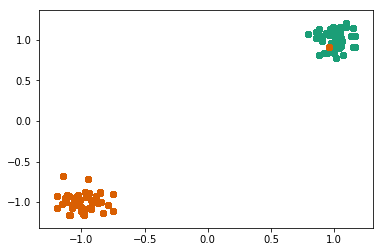

In [17]:
plot_segmentation(post)

In [18]:
#show the envent number that was chosen. Notice the re-use of events
np.argmax(post, axis=1)

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

In [19]:
post = sem2.run(x_train, K=K)

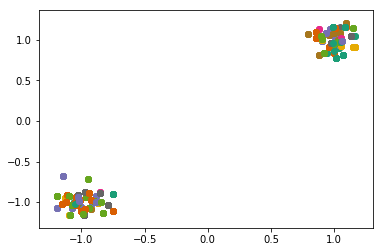

In [20]:
plot_segmentation(post)

In [21]:
#show the envent number that was chosen. Notice the re-use of events
np.argmax(post, axis=1)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 16,  2, 14,  1,  5,  9,  1,  1, 15,  0, 15,  9,  5,  5,
       14, 10,  2, 18,  8,  4,  4,  4,  4,  4, 17, 10, 10, 10, 15, 17,  8,
        8, 18,  3,  6,  2, 13,  4, 12, 14,  2, 15,  1,  1,  4,  4,  6,  6,
        6,  8,  8,  8,  8,  5,  5, 13, 17,  3,  1,  1,  4,  4,  4,  4, 15,
       15, 15, 15, 17, 17, 17, 17, 17, 18,  8, 18, 18, 12, 12, 12])

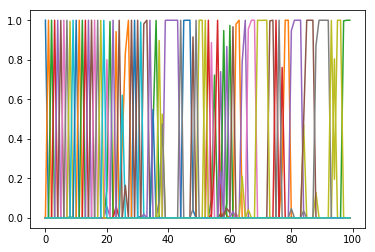

In [22]:
plt.plot(post)
plt.show()

In [23]:
post = sem3.run(x_train, K=K)

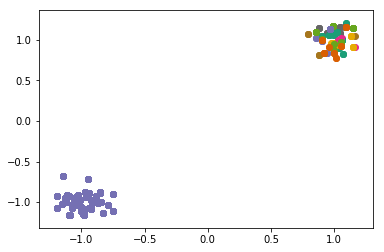

In [24]:
plot_segmentation(post)

In [25]:
np.argmax(post, axis=1)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 12,  0, 13, 14,
       15, 16, 17, 10, 18, 15, 12, 19,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2, 12,
        7,  7,  7, 16, 16,  6, 12, 16, 16,  5,  5, 10,  9,  9,  8,  8,  3,
        6,  5, 12, 12,  1,  9,  9,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2])

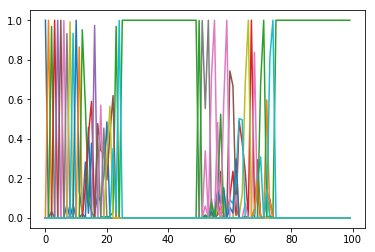

In [26]:
plt.plot(post)
plt.show()

Below an example of two events where the events correspond to movement in vector space

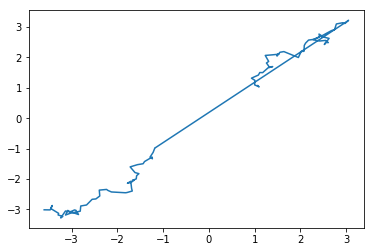

In [27]:
def build_moving_data(N, beta=0.01):
    pi = np.array([0.4, 0.6])
    bs = [[1, 1], [-1, -1]]  # starting point!
    ws = [np.array([[1, 0], [.5, 2]]), np.array([[-1, .2], [-.2, 1]])]
    stds = np.eye(2) * beta
    x = np.zeros((N, 2), dtype=np.float32)
    
    x[0, :] = np.random.multivariate_normal(bs[0], stds)
    for n in range(1, N/2):
        _x = x[n-1, :] + np.array([0.05, 0.05])
        x[n, :] = np.random.multivariate_normal(_x, stds)
        
    x[N/2, :] = np.random.multivariate_normal(bs[1], stds)
    for n in range(N/2+1, N):
        _x = x[n-1, :] + np.array([-0.05, -0.05])
        x[n, :] = np.random.multivariate_normal(_x, stds)
    return x

x_train = build_moving_data(100)
plt.plot(x_train[:, 0], x_train[:, 1])

In [28]:
post = sem.run(x_train, K=K)

sem.py:369: RuntimeWarning: divide by zero encountered in log
  return np.log(multivariate_normal.pdf(Y - Y_hat, mean=np.zeros(self.D), cov=Sigma))


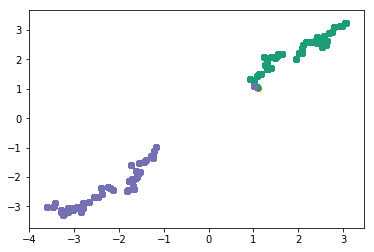

In [29]:
plot_segmentation(post)

In [30]:
np.argmax(post, axis=1)

array([0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2])

In [31]:
post = sem2.run(x_train, K=K)

sem.py:67: RuntimeWarning: divide by zero encountered in log
  LL = np.log(multivariate_normal.pdf(Y - Y_hat, mean=np.zeros(self.D), cov=Sigma))
sem.py:495: RuntimeWarning: invalid value encountered in subtract
  post[n, :len(active)] = np.exp(p - logsumexp(p))


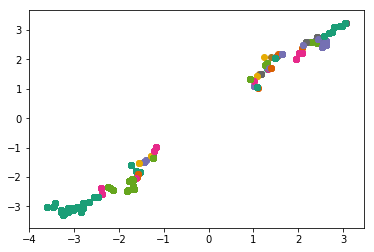

In [32]:
plot_segmentation(post)

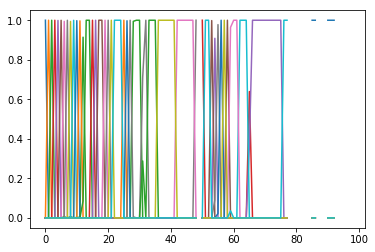

In [33]:
plt.plot(post)
plt.show()

In [34]:
post = sem3.run(x_train, K=K)

In [35]:
#show the envent number that was chosen. Notice the re-use of events
np.argmax(post, axis=1)

array([ 0,  1,  2,  3,  4,  5,  5,  6,  7,  8,  8,  9, 10, 10, 10, 10, 11,
       11, 11, 12, 12,  1,  1, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14,
       15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16,  5,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8])

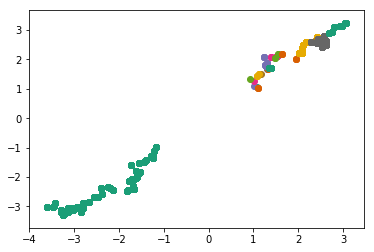

In [36]:
plot_segmentation(post)

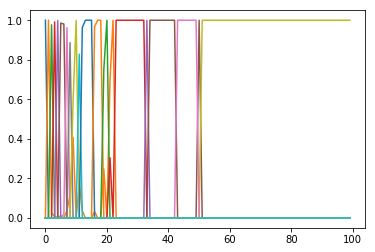

In [37]:
plt.plot(post)
plt.show()

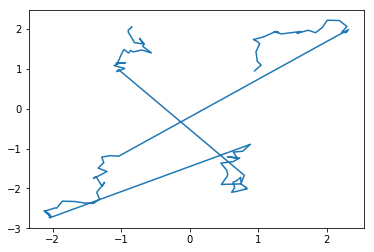

In [38]:
def build_alternating_moving_events(N, beta=0.01):
    pi = np.array([0.4, 0.6])
    bs = [[1, 1], [-1, -1], [1, -1], [-1, 1]]  # starting point!
    ws = [np.array([[1, 0], [.5, 2]]), np.array([[-1, .2], [-.2, 1]])]
    Sigma = np.eye(2) * beta
    x = np.zeros((N, 2), dtype=np.float32)
    
    x[0, :] = np.random.multivariate_normal(bs[0], Sigma)
    for n in range(1, N/4):
        _x = x[n-1, :] + np.array([0.05, 0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigma)
        
    x[N/4, :] = np.random.multivariate_normal(bs[1], Sigma)
    for n in range(N/4+1, N/2):
        _x = x[n-1, :] + np.array([-0.05, -0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigma)
            
    x[N/2, :] = np.random.multivariate_normal(bs[2], Sigma)
    for n in range(N/2+1, N/4*3):
        _x = x[n-1, :] + np.array([-0.05, -0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigma)
        
    x[N/4*3, :] = np.random.multivariate_normal(bs[3], Sigma)
    for n in range(N/4*3+1, N):
        _x = x[n-1, :] + np.array([0.05, 0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigma)      
        
    return x

x_train = build_alternating_moving_events(100)
plt.plot(x_train[:, 0], x_train[:, 1])

In [39]:
post = sem.run(x_train, K=K)

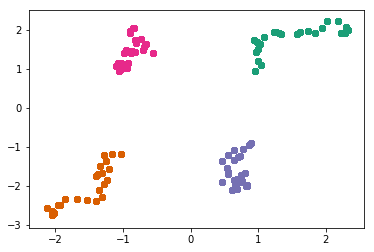

In [40]:
plot_segmentation(post)

In [41]:
np.argmax(post, axis=1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3])

In [42]:
post = sem2.run(x_train, K=K)

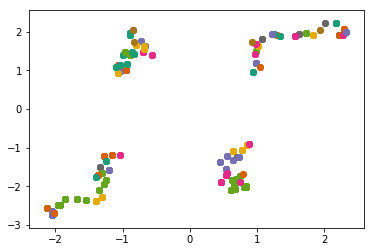

In [43]:
plot_segmentation(post)

In [44]:
np.argmax(post, axis=1)

array([ 0,  1,  2,  3,  4,  5,  3,  6,  7,  8,  9, 10,  8,  7, 11, 12, 13,
       14, 15, 16, 17, 17, 18, 19, 10,  3, 17, 17,  0,  7,  2,  4,  8, 17,
       12, 12, 12,  5,  5,  4,  4,  4,  4,  4,  4,  4, 17, 17,  2,  2, 11,
        5,  5,  5,  7, 18, 18, 18,  2,  2, 11, 11, 11, 11,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  9,  2,  5, 17, 16, 16, 16,  1, 19,  8, 12,
       12,  0,  0, 11,  3, 13, 10, 10, 13, 13, 14, 16, 16, 15,  6])

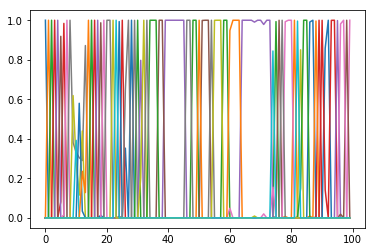

In [45]:
plt.plot(post)
plt.show()

In [46]:
post = sem3.run(x_train, K=K)

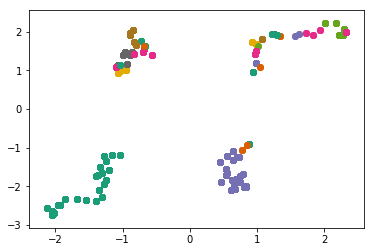

In [47]:
plot_segmentation(post)

In [48]:
np.argmax(post, axis=1)

array([ 0,  1,  2,  3,  3,  4,  5,  5,  6,  7,  8,  8,  9, 10, 10, 11, 11,
       11, 12, 12, 12, 12, 12, 12,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        9,  9,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  5,  5,  5,  3,  8,  7,  7,  4,  7,  7,
        7,  7,  3,  3,  3,  3,  8,  8,  1,  6,  6,  6,  6,  6,  6])

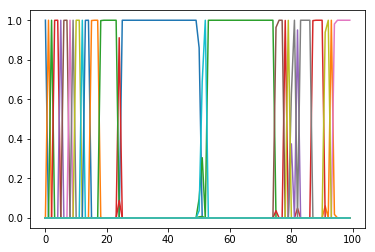

In [49]:
plt.plot(post)
plt.show()

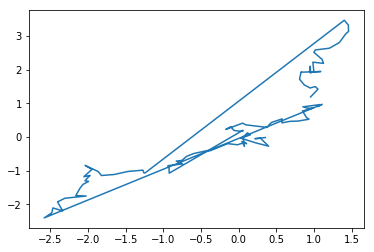

In [50]:
def build_alternating_moving_events(N, beta=0.01):
    pi = np.array([0.4, 0.6])
    bs = [[1, 1], [-1, -1], [1, -1], [-1, 1]]  # starting point!
    ws = [np.array([[1, 0], [.5, 2]]), np.array([[-1, .2], [-.2, 1]])]
    Sigma = np.eye(2) * beta
    x = np.zeros((N, 2), dtype=np.float32)
    
    x[0, :] = np.random.multivariate_normal(bs[0], Sigma)
    for n in range(1, N/4):
        _x = x[n-1, :] + np.array([0.05, 0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigma)
        
    x[N/4, :] = np.random.multivariate_normal(bs[1], Sigma)
    for n in range(N/4+1, N/2):
        _x = x[n-1, :] + np.array([-0.05, -0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigma)
            
    x[N/2, :] = np.random.multivariate_normal(bs[0], Sigma)
    for n in range(N/2+1, N/4*3):
        _x = x[n-1, :] + np.array([-0.05, -0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigma)
        
    x[N/4*3, :] = np.random.multivariate_normal(bs[1], Sigma)
    for n in range(N/4*3+1, N):
        _x = x[n-1, :] + np.array([0.05, 0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigma)      
        
    return x

x_train = build_alternating_moving_events(100)
plt.plot(x_train[:, 0], x_train[:, 1])

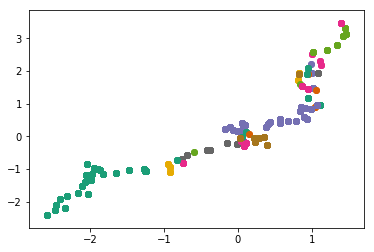

In [51]:
plot_segmentation(post)

In [52]:
post = sem2.run(x_train, K=K)

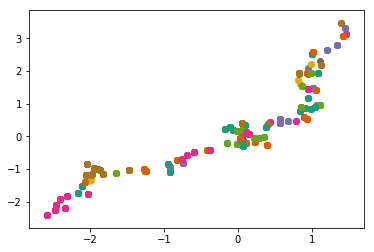

In [53]:
plot_segmentation(post)

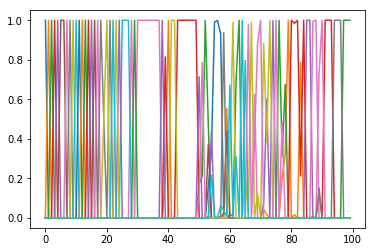

In [54]:
plt.plot(post)
plt.show()

In [ ]:
post = sem3.run(x_train, K=K)

In [ ]:
plot_segmentation(post)